# 1) Workspace setup and data import

The original data can be downloaded [here](https://www.kaggle.com/mlg-ulb/creditcardfraud).

In [ ]:
# General libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression

# Recursive feature elimination
from sklearn.feature_selection import RFE, RFECV

# Model Evaluation
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

# Other Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score


# from sklearn.pipeline import make_pipeline
# from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
# from imblearn.under_sampling import NearMiss
# from imblearn.metrics import classification_report_imbalanced
# import collections
# from collections import Counter
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Import data into pandas dataframe
data = pd.read_csv('.../creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# 2) Understanding the data
According to the documentation, the dataset contains transactions made by credit cards in September 2013, over two days, by European cardholders.

The 31 columns of the dataset only contain numerical input variables, which are the result of a PCA transformation of the original dataset. Features V1, V2, … V28 are the principal components obtained with PCA, and the only features which have not been transformed with PCA are 'Time' and 'Amount'. The original features are not provided due to  confidentiality issues.
* 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset.
* 'Amount' is the transaction amount

**Summary**:
* There are no null values in any of the columns of the dataset.
* Out of 284,807 transactions, 492 (0.17%) were considered to be frauds (ie, 'Class' = 1). 
* This means that the dataset is **extremely unbalanced**. This issue is further discussed in section 4.

In [ ]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [ ]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
# There are no null values in the data
data.isna().sum().max()

0

The dataset contains 284807 transactions.
Fraud transactions: 492 (0.17%).
Legitimate transactions: 284315 (99.83%).


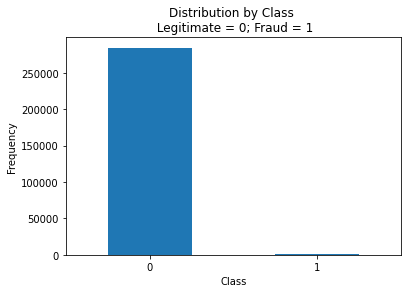

In [ ]:
print("The dataset contains", len(data),"transactions.")
print("Fraud transactions: %i (%.2f%%)." % (data['Class'].value_counts()[1], data['Class'].value_counts()[1]/len(data) * 100))
print("Legitimate transactions: %i (%.2f%%)." % (data['Class'].value_counts()[0],data['Class'].value_counts()[0]/len(data) * 100))

# Ploting the transactions by Class
count_classes = data.value_counts(data['Class']).sort_index()
count_classes.plot(kind = 'bar', title = "Distribution by Class \n Legitimate = 0; Fraud = 1", xlabel = "Class", ylabel = "Frequency", rot = 0)


Amounts of fraudlent transactions: 
 Mean: 122 
 Median: 9 
 Max Amount: 2125 
 

Amounts of legitimate transactions: 
 Mean: 88 
 Median: 22 
 Max Amount: 25691



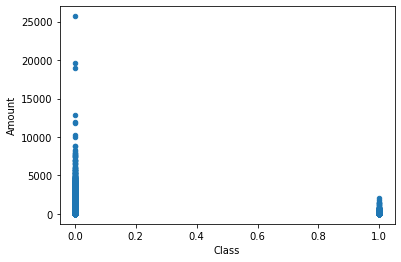

In [ ]:
# Plotting column 'Amount' against 'Class'
# The graph shows that the majority of frauds happen in transactions with lower amounts

data.plot(kind = 'scatter', x = 'Class', y = 'Amount')

fraud_amount = data.loc[data['Class'] == 1, 'Amount']
legit_amount = data.loc[data['Class'] == 0, 'Amount']

print("""
Amounts of fraudulent transactions: \n Mean: %d \n Median: %d \n Max Amount: %d \n \n
Amounts of legitimate transactions: \n Mean: %d \n Median: %d \n Max Amount: %d
"""
% (fraud_amount.mean(), fraud_amount.median(), fraud_amount.max(), legit_amount.mean(), legit_amount.median(), legit_amount.max()))

# 3) Scaling

As mentioned previously, a PCA was performed in the original dataset and the V features (V1 to V28) are the obtained Principal Components of that transformation. The only features which have not been transformed with PCA are 'Time' and 'Amount'.

In order to perform a PCA the features must be normalized first. Hence, we can assume that is what the authors of the dataset did regarding the V features. Therefore, columns 'Time' and 'Amount' must be scaled (normalized) as the other columns.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Create scaled columns 'scaled_amount' and 'scaled_time'
data['scaled_amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data['scaled_time'] = StandardScaler().fit_transform(data['Time'].values.reshape(-1, 1))

# Removing old 'Amount' and 'Time' columns
data.drop(['Amount', 'Time'], axis = 1, inplace = True)

# Scaling complete
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964,-1.996583
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475,-1.996583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686,-1.996562
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534,-1.996562
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403,-1.996541


# 4) Unbalanced data and subsampling

The large amount of identified legitimate transactions versus frauds suggests that this is an **unbalanced dataset**.

By testing a model on an unbalanced dataset the accuracy and overall usefulness of such model can be seriously compromised due to:
* Overfitting: the model will be unable to effectively understand and identify patterns in the data due to the higher amount of legitimate transactions.
* Faulty correlations: as we will see, features in the unbalanced dataset hardly show any correlation, which could impact the performance of the model.

There are a few methods that can be used to deal with this problem:
1. Collect more data;
2. Change the performance metric;
3. Resample the dataset.

In this section we will focus on the last solution by applying a **random under-sample** technique.

In short, under-sampling removes instances of the over-represented class (in this case, legitimate transactions), in order to archive a balance between classes. Our approach will be to generate a subsample with a 50/50 ratio (i.e., same amount) of fraud and legitimate transactions.

*Note: This approach has a few shortcomings that will be discussed in the later sections of the notebook.*

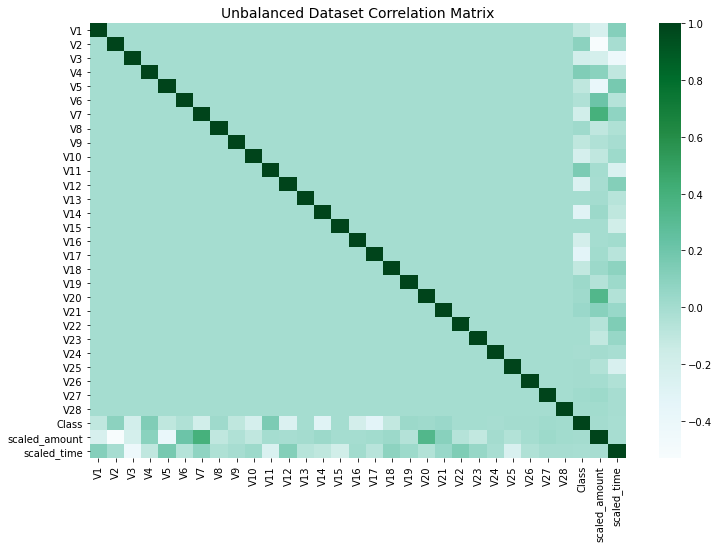

In [ ]:
# To showcase the problems with the correlations in the unbalanced dataset, let us display the correlation matrix for the whole dataset.

# Create sample figsize in inches
fig, ax = plt.subplots(figsize=(12,8))

# Unbalanced DataFrame Correlation
corr = data.corr()
sns.heatmap(corr, cmap='BuGn', ax=ax)
ax.set_title("Unbalanced Dataset Correlation Matrix", fontsize=14)
plt.show()

## 4.1) Training subsample
### Generating a balanced subsample

In this section we will apply the random under-sample technique to generate a "balanced" subsample, in which the number of legitimate transactions is equal to the number of fraudulent transactions.

Steps:
1. Determine the number of occurrences of the under-represented class (number of frauds = 492);
2. Bring the number of the over-represented class "down" to the same amount (randomly select 492 legitimate transactions);
3. And thus generate a subsample of the dataframe with a 50/50 ratio with regards to the classes.

In [ ]:
# Generate balanced subsample

# Shuffle the data to randomize selection of legitimate cases
new_df = data.sample(frac=1)

# Number of fraudulent transactions:
no_fraud = data['Class'].value_counts()[1]      # 492

# Separate dataset by class
fraud_df = new_df.loc[new_df['Class'] == 1]
legit_df = new_df.loc[new_df['Class'] == 0][:no_fraud]

# Concatenate the two dataframes
new_df = pd.concat([fraud_df, legit_df])
# And shuffle the new dataframe
new_df = new_df.sample(frac=1, random_state=19)

new_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
200580,-3.308348,-0.914141,-1.650619,-1.288784,1.002869,-0.846744,1.080358,0.249428,-2.413760,0.138586,-0.229478,-0.237314,-0.346950,1.231089,-1.067350,-1.473002,-0.059541,1.568451,0.054796,-1.803464,-0.387903,0.316150,0.734238,0.277643,1.778519,1.189121,-0.203270,-0.368585,0,0.233250,0.814460
282567,1.938498,-0.270778,-1.412667,-0.008288,0.797130,0.914555,-0.177881,0.281718,0.336101,0.114028,1.001623,1.094878,-0.089186,0.542143,0.164013,-0.590282,0.064640,-1.495831,-0.392207,-0.297822,-0.200522,-0.374814,0.336150,-1.634985,-0.462517,0.310578,-0.026235,-0.087726,0,-0.350471,1.604196
203700,1.204934,3.238070,-6.010324,5.720847,1.548400,-2.321064,-0.781880,0.076619,-2.976249,-4.070257,3.394152,-4.547742,-0.063634,-10.516465,0.053267,0.204080,0.462929,0.841169,-2.221384,0.338161,0.098341,-0.845866,-0.031228,0.421146,0.388361,0.056035,0.491828,0.340847,1,-0.353229,0.844721
153718,1.977147,-0.142588,-0.822587,1.689398,0.137897,0.230618,-0.301322,0.033294,2.664173,-0.341931,-1.049219,-2.783509,-0.253273,1.496767,-2.196292,-0.733963,0.911089,-0.372339,0.163479,-0.421441,-0.527528,-0.986647,0.267859,0.273225,0.024598,-0.863874,-0.000989,-0.049691,0,-0.317247,0.107293
14170,-15.903635,10.393917,-19.133602,6.185969,-12.538021,-4.027030,-13.897827,10.662252,-2.844954,-9.668789,7.394419,-11.635630,1.423277,-8.640459,-0.674720,-7.695569,-13.684140,-4.777406,1.268343,1.501565,1.577548,-1.280137,-0.601295,0.040404,0.995502,-0.273743,1.688136,0.527831,1,0.046539,-1.465965



Number of transactions in the balanced subsample: 984
Number of fraudlent transactions: 492 (50%)
Number of legitimate transactions: 492 (50%)



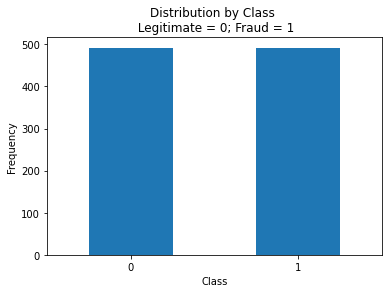

In [ ]:
# The subsample is balanced with regards to the classes

print("""
Number of transactions in the balanced subsample: %i
Number of fraudulent transactions: %i (%i%%)
Number of legitimate transactions: %i (%i%%)
""" % (len(new_df), new_df['Class'].value_counts()[1],new_df['Class'].value_counts()[1]/len(new_df)*100, new_df['Class'].value_counts()[0], new_df['Class'].value_counts()[0]/len(new_df)*100))

# Ploting the transactions by Class in subsample
count_classes_new_df = new_df.value_counts(new_df['Class']).sort_index()
count_classes_new_df.plot(kind = 'bar', title = "Distribution by Class \n Legitimate = 0; Fraud = 1", xlabel = "Class", ylabel = "Frequency", rot = 0)

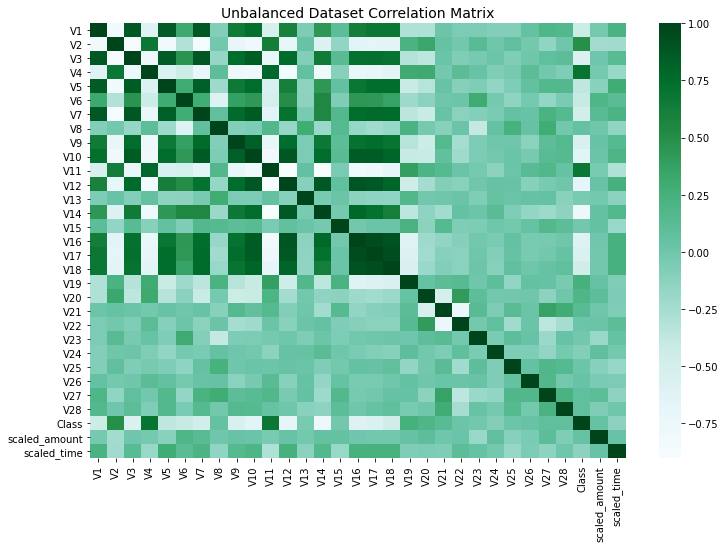

In [ ]:
# Also, the previously mentioned problems with the correlations are now greatly reduced.

fig, ax1 = plt.subplots(figsize=(12,8))

# Balanced dataframe correlation
corr = new_df.corr()
sns.heatmap(corr, cmap='BuGn', ax = ax1)
ax1.set_title("Unbalanced Dataset Correlation Matrix", fontsize=14)
plt.show()

# 5) Logistic Regression Classifier

This section will be comprised as follows:

1. Feature selection using Recursive Feature Elimination and Cross-Validation (RFECV). The pruned features will be removed from the balanced subsample.
2. Splitting the new balanced dataset into training and testing subsets.
3. Determine the parameters that give the best predictive cross-validation score using GridSearchCV.
4. Logistic Regression model evaluation (cross-validation score, classification report, confusion matrix).


The classifier will be evaluated regarding its accuracy measures.

Finally, we'll generate predictions on the training data using the developed model.

### 1) Feature selection using RFECV

RFECV performs Recursive Feature Elimination (RFE) in a cross-validation loop to find the optimal number or the best number of features. It also returns the best features to include in the model.

[Source](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV).

In [ ]:
# Create X (features) and y (response/check)
X = new_df.drop('Class',axis=1)
y = new_df['Class']

# Logistic Regression Model
lr = LogisticRegression()

# Use accuracy score as the scorer
rfecv = RFECV(estimator = lr, step=1, cv=5, scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))

# Removing pruned features from balanced subsample.
X = X[list(X.columns[rfecv.support_])]

Optimal number of features: 5
Selected features: ['V4', 'V12', 'V14', 'V25', 'V26']


### 2) Split subsample into training and testing subsets

In [ ]:
# 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

### 3) Determine the best parameters (GridSearchCV)

In [ ]:
# Fit a Logistic Regression classifier into the training data
lr = LogisticRegression().fit(X_train, y_train)

# We can check the cross-validation score of this "untouched" model:
print("Pre-GridSearchCV Cross Validation Score: ", round(cross_val_score(lr, X_train, y_train).mean(),3)*100, "%")


# Using GridSearchCV to figure out the parameters that return the best cross-validation score

# Parameter grid:
lr_params = {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_lr = GridSearchCV(estimator = LogisticRegression(), param_grid = lr_params)
grid_lr.fit(X_train, y_train)

# The Logistic Regression model with the best parameters:
lr = grid_lr.best_estimator_
print("\nPost-GridSearchCV Cross Validation Score: ", round(cross_val_score(lr, X_train, y_train).mean(),3)*100, "%")

Pre-GridSearchCV Cross Validation Score:  93.30000000000001 %

Post-GridSearchCV Cross Validation Score:  93.4 %


### 4) Logistic Regression model evaluation

In [ ]:
# Evaluation on training set
y_pred_train = lr.predict(X_train)
y_pred_train_prob = lr.predict_log_proba(X_train)[:, 1]
[fpr, tpr, thr] = roc_curve(y_train, y_pred_train_prob)
training_score = accuracy_score(y_train, y_pred_train)

print(lr.__class__.__name__, " training accuracy score: %2.3f" % training_score)
print(lr.__class__.__name__," auc is %2.3f" % auc(fpr, tpr))
print(lr.__class__.__name__, " training classification report:", "\n", classification_report(y_train, y_pred_train))

LogisticRegression  training accuracy score: 0.934
LogisticRegression  auc is 0.973
LogisticRegression  training classification report: 
               precision    recall  f1-score   support

           0       0.90      0.98      0.94       393
           1       0.97      0.89      0.93       394

    accuracy                           0.93       787
   macro avg       0.94      0.93      0.93       787
weighted avg       0.94      0.93      0.93       787



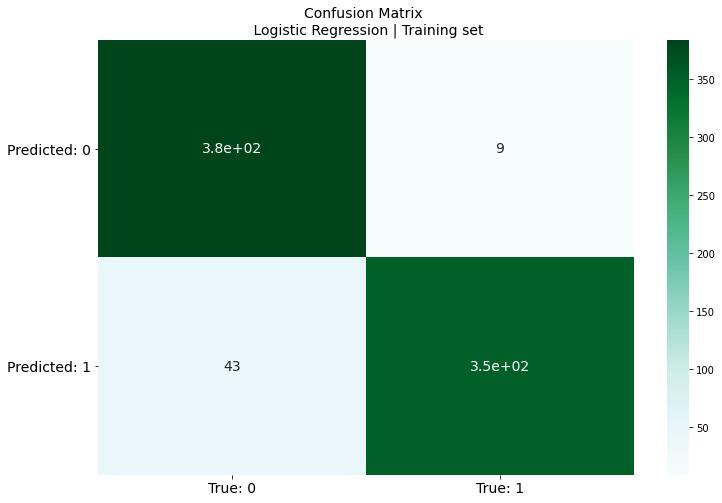

In [ ]:
# Confusion Matrix on training set
lr_cf_training = confusion_matrix(y_train, y_pred_train)

fig, ax = plt.subplots(figsize=(12,8))

sns.heatmap(lr_cf_training, ax=ax, annot=True, annot_kws={"fontsize":14}, cmap='BuGn')
ax.set_title("Confusion Matrix \n Logistic Regression | Training set", fontsize=14)
ax.set_xticklabels(['True: 0', 'True: 1'], fontsize=14)
ax.set_yticklabels(['Predicted: 0', 'Predicted: 1'], fontsize=14, rotation=360)
plt.show()

In [ ]:
# Evaluation on test set (predictions)
y_pred = lr.predict(X_test)
y_pred_prob = lr.predict_log_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_prob)
testing_score = accuracy_score(y_test, y_pred)

print(lr.__class__.__name__, " training accuracy score: %2.3f" % testing_score)
print(lr.__class__.__name__," auc is %2.3f" % auc(fpr, tpr))
print(lr.__class__.__name__, "testing classification report:", "\n", classification_report(y_test, y_pred))

LogisticRegression  training accuracy score: 0.939
LogisticRegression  auc is 0.991
LogisticRegression testing classification report: 
               precision    recall  f1-score   support

           0       0.91      0.98      0.94        99
           1       0.98      0.90      0.94        98

    accuracy                           0.94       197
   macro avg       0.94      0.94      0.94       197
weighted avg       0.94      0.94      0.94       197



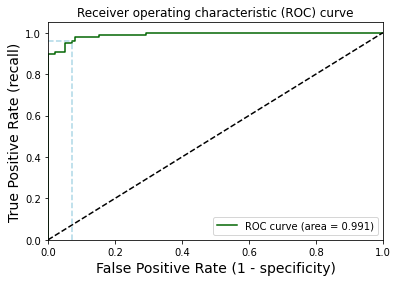


Using a threshold of -1.451 guarantees a sensitivity of 0.959 and a specificity of 0.929, i.e. a false positive rate of 7.07%.


In [ ]:
# ROC Curve

idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensibility > 0.95

plt.figure()
plt.plot(fpr, tpr, color='darkgreen', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='lightblue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='lightblue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("\nUsing a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))


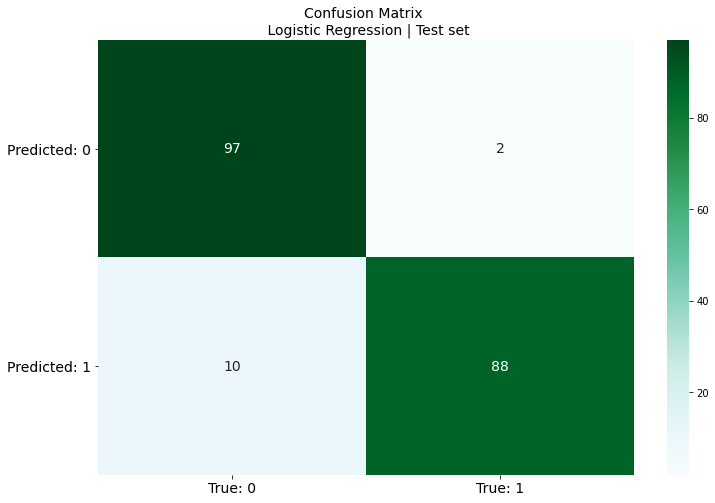

In [ ]:
# Confusion Matrix on training set
lr_cf= confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(12,8))

sns.heatmap(lr_cf, ax=ax, annot=True, annot_kws={"fontsize":14}, cmap='BuGn')
ax.set_title("Confusion Matrix \n Logistic Regression | Test set", fontsize=14)
ax.set_xticklabels(['True: 0', 'True: 1'], fontsize=14)
ax.set_yticklabels(['Predicted: 0', 'Predicted: 1'], fontsize=14, rotation=360)
plt.show()

# 6) Conclusions

* The model has an accuracy score of 0.95
* A precision of 0.93
* And a recall of 0.97
* Area under the ROC Curve: 0.986

*Note: Results might vary due to the random subsample generation (section 4.1).*

# 7) Improvements and Next Steps

1. Problems with random under-sampling

The main issue with random under-sampling is information loss, since we generate from a dataset with 284,807 observations a sample with (only) 984 transactions.

**Possible solution**: Apply other subsampling technique, for example [SMOTE](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/).

2. Under/over-sampling during cross-validation

When dealing with unbalanced dataset, the order of events in the process of sampling take a whole other level of importance. It is highly recommended to **perform sampling during cross-validation** to avoid overfitting and "data-leakage" problems. Such technique would also allow to use the whole dataset for training and testing. [Learn more](https://www.marcoaltini.com/blog/dealing-with-imbalanced-data-undersampling-oversampling-and-proper-cross-validation).

3. Lack of data pre-processing

There is still room to perform more data pre-processing, for instance by inspecting the data for outliers or extremely correlated features.

4. Testing other classifiers

Despite the robustness of Logistic Regression, an interesting exercise would be to evaluate the performance of this classifier against other algorithms, such as Random Forest, Decision Tree, Support Vector Classifier, etc.